In [484]:
import numpy as np
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [1]:
def tensor(A, B):
    m = len(A)*len(B)
    n = len(A[0])*len(B[0])

    prod = []

    for i in range(m):
        prod.append([])
        for j in range(n):
            ax = int(i / len(B))
            ay = int(j / len(B[0]))
            bx = int(i % len(B))
            by = int(j % len(B[0]))
            prod[i].append(A[ax][ay]*B[bx][by])

    return np.array(prod)

def tensor_list(ops):
    prod = ops[-1]
    for i in range(len(ops)-2, -1, -1):
        prod = tensor(ops[i], prod)
    return np.array(prod)

def pauli(pos, dir, N):
    factors = [[[1, 0], [0, 1]]]*N
    if dir == 'x':
        factors[pos] = [[0, 1], [1, 0]]
    elif dir == 'y':
        factors[pos] = [[0, -1j], [1j, 0]]
    elif dir == 'z':
        factors[pos] = [[1, 0], [0, -1]]

    return tensor_list(factors)

def on_site_detuning(pos, N):
    sum = 0
    for j in range(N):
        if np.abs(pos - j) == 1:
            sum += V_nn
        elif np.abs(pos - j) == 2:
            sum += V_nnn

    return -0.5 * sum

def interaction_strength(pos1, pos2):
    if np.abs(pos1 - pos2) == 1:
        return V_nn
    if np.abs(pos1 - pos2) == 2:
        return V_nnn
    else:
        return 0

In [518]:
(pauli(0, 'i', 2) + pauli(0, 'z', 2))/2 @ (pauli(1, 'i', 2) + pauli(1, 'z', 2))/2

expm([[0, 0, -3j], [0, 0, -3j], [-3j, -3j, 0]])

expm([[-1j, 0], [0, 1j]]) @ [[0.5, 0.5], [0.5, 0.5]] @ expm([[1j, 0], [0, -1j]])

array([[ 0.5       -1.17097932e-17j, -0.20807342-4.54648713e-01j],
       [-0.20807342+4.54648713e-01j,  0.5       +1.17097932e-17j]])

In [487]:
def hamiltonian(N, rabi_f, delta, V_nn, V_nnn):
    H = 0.5 * rabi_f * sum([pauli(i, 'x', N) for i in range(N)])
    H -= 0.5 * sum([(delta + on_site_detuning(i, N)) * pauli(i, 'z', N) for i in range(N)])

    interaction_term = sum([sum([interaction_strength(i, j) * pauli(i, 'z', N) @ pauli(j, 'z', N) for j in range(N)]) for i in range(N)])
    H += 0.125 * interaction_term
    return H

In [488]:
def gram_schmidt(v, basis):
    proj = sum([np.dot(v, b) * b for b in basis])
    w = v - proj
    # if v \in span(basis), we have reached dimension of Krylov subspace
    if np.linalg.norm(w) <= 0.001:
        return []
    return w / np.linalg.norm(w)

def krylovbasis(H, psi0, dim):
    kbasis = np.transpose(psi0)/np.linalg.norm(psi0)
    for i in range(dim-1):
        next_v = np.dot(H, kbasis[-1])
        next_v = gram_schmidt(next_v, kbasis) # orthonormalize
        if len(next_v) == 0:
            break
        kbasis = np.append(kbasis, [next_v], axis=0)

    return kbasis

def diag_power(S, n):
    for i in range(len(S)):
        S[i][i] = S[i][i]**n
    return S

# custom implementation runs into issues with numerical stability that scipy solves
# scipy uses Pade approximation, this is just an eigendecomp
def mat_exp(S):
    eigenvalues, U_inv = np.linalg.eig(S)
    U = np.linalg.inv(U_inv)
    D = np.diag([np.exp(eig) for eig in eigenvalues])
    return U @ D @ U_inv

def expectation(op, psi):
    return np.dot(np.conj(psi), np.dot(op, psi))

def krylovsolve(H, psi0, tlist, krylov_dim, e_ops=[]):
    psi = np.transpose(psi0)[0]
    probs = np.array([np.abs(np.transpose(psi0)[0])**2])
    expect = [[expectation(op, psi)] for op in e_ops]

    V = np.conj(krylovbasis(H, psi0, krylov_dim))
    # print(V)
    V_dag = np.conj(np.transpose(V))
    T = V @ H @ V_dag

    # expme = U @ sum([((complex(0, -trotter)**j)/math.factorial(j)) * diag_power(D, j) for j in range(40)]) @ U_inv

    for i in range(len(tlist)-1):
        time_ev = V_dag @ expm(complex(0, -tlist[i])*T) @ V
        
        # time_ev = V_dag @ mat_exp(complex(0, -tlist[i]) * T) @ V
        psi_new = np.dot(time_ev, psi)

        probs = np.append(probs, [np.abs(psi_new)**2], axis=0)

        for o in range(len(e_ops)):
            expect[o] = np.append(expect[o], [expectation(e_ops[o], psi_new)], axis=0)
    return [expect, probs]

In [490]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 3

psi0 = tensor_list([[[0], [1]]] * N)
tlist = np.linspace(0.0, 475*(10**-9), 200)
probs = krylovsolve(hamiltonian(N, rabi_f, 0, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40))[1]

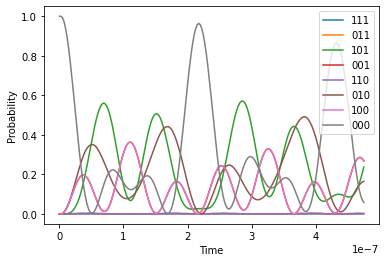

In [491]:
plt.figure()
for s in range(8):
   plt.plot(tlist, probs[:, s])
plt.legend(('111', '011', '101', '001', '110', '010', '100', '000'))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()

In [ ]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 2

psi0 = [[0], [0], [1]]
tlist = np.linspace(0.0, 475*(10**-9), 200)
# probs = np.abs(krylovsolve(hamiltonian(N, rabi_f, 0, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40)).states)**2
h = np.array([[0, 0, 1], [0, 0, 1], [1, 1, 0]])
probs = krylovsolve(h, psi0, tlist, krylov_dim=min(2**N, 40))[1]

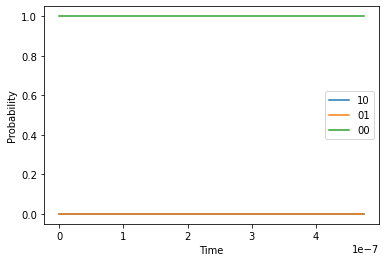

In [501]:
plt.figure()
for s in range(3):
   plt.plot(tlist, probs[:, s])
plt.legend(('10', '01', '00'))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()

In [492]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 5
psi0 = tensor_list([[[0], [1]]] * N)
expect_z = [krylovsolve(hamiltonian(N, rabi_f, 0, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40), e_ops=[pauli(i, 'z', N)])[0][0] for i in range(N)]

/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


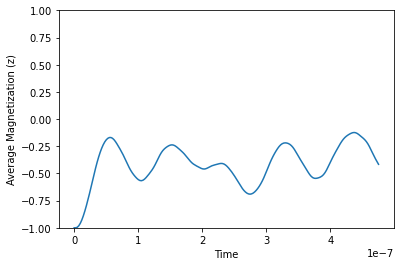

In [493]:
plt.figure()
plt.plot(tlist, np.mean(expect_z, axis=0))
plt.xlabel('Time')
plt.ylabel('Average Magnetization (z)')
plt.ylim(-1, 1)
plt.show()

/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

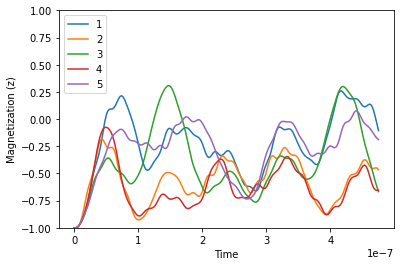

In [494]:
plt.figure()
for s in range(N):
   plt.plot(tlist, expect_z[s])
plt.legend([i+1 for i in range(N)])
plt.xlabel('Time')
plt.ylabel('Magnetization (z)')
plt.ylim(-1, 1)
plt.show()

In [495]:
rabi_f = 2*np.pi*0.9*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
delta = 2*np.pi*2.2*(10**6)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
N = 8
psi0 = tensor_list([[[0], [1]]] * N)
tlist = np.linspace(0.0, 2*(10**-6), 200)

data = []

for d in range(N):
    avg = np.zeros(len(tlist))
    for i in range(N-d):
        result = krylovsolve(hamiltonian(N, rabi_f, delta, V_nn, V_nnn), psi0, tlist, krylov_dim=min(2**N, 40), e_ops=[pauli(i, 'z', N), pauli(i+d, 'z', N), pauli(i, 'z', N)*pauli(i+d, 'z', N)])
        avg += np.abs(result[0][2] - result[0][0]*result[0][1])
    avg /= (N-d)
    data.append(0.25 * avg)

data = np.transpose(data)

KeyboardInterrupt: 

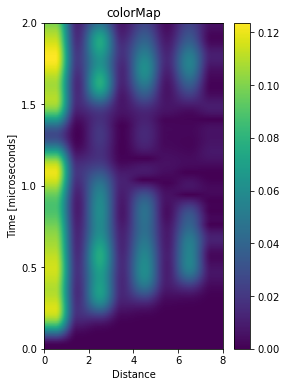

In [ ]:
fig = plt.figure(figsize=(4, 6))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(data, origin='lower', extent=[0, N, 0, 2])
ax.set_aspect('auto')

ax.set_yticks(np.linspace(0, 2, 5))

plt.xlabel("Distance")
plt.ylabel("Time [microseconds]")
plt.colorbar(orientation='vertical')
plt.show()